In [2]:
import qecc as q
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from math import *
import random


# Implementation of utility function 

In [3]:
def Delta(S):
    """
    Return the simplectic gram graph of S a set of distinct Paulies.
    """
    G = nx.Graph()
    authorized_nodes = [i for i in range(len(S))]
    G.add_nodes_from(authorized_nodes)
    for i in authorized_nodes:
        for j in range(i):
            if  S[i]*S[j] != S[j]*S[i]:
                G.add_edge(i, j)
    return G

In [4]:
def draw(G):
    # Function to draw a canonical form 
    nx.draw_circular(G, with_labels=True)

The canonical form of Pauly strings on 2 qubits

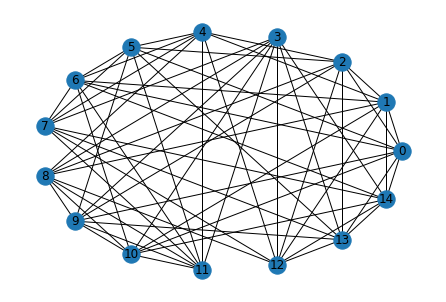

In [5]:
N=2
S = list(q.pauli_group(N))[1:]
G = Delta(S)
draw(G)

Utility function to gets a clique of size 2n+1.

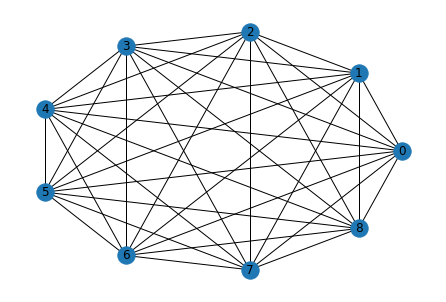

In [6]:
N=4
def getLIclique(n):
    B=[q.Pauli.from_sparse({0:q.X}, nq=n), q.Pauli.from_sparse({0:q.Y}, nq=n), q.Pauli.from_sparse({0:q.Z}, nq=n)]
    for i in range(1, n):
        B = [p*q.Pauli.from_sparse({i:q.X}, nq=n) for p in B] + [q.Pauli.from_sparse({i:q.Y}, nq=n), q.Pauli.from_sparse({i:q.Z}, nq=n)]
    return B

S = getLIclique(N)
Sd = Delta(S)
draw(Sd)

# Implementation of the Symplectico Gram Schmidt algorithm

In [7]:

def star_op(B, e_k, f_k):
    B[e_k] = B[e_k] * B[f_k]
    return Delta(B)

def simplecticnormalization(nq, B):
    G = Delta(B)
    Q = []
    M = np.zeros((len(B), 2*nq))
    for i in range(min(len(B),2*nq)):
        M[i,i] = 1
    while max(map(lambda x : x[1], G.degree()))>1:
        e_k, f_k = [e for e in G.edges() if G.degree(e[0]) > 1 or G.degree(e[1]) > 1][0]
        if G.degree(e_k) < 2:
            e_k, f_k = f_k, e_k
        for v in G.neighbors(e_k):
            if v != f_k:
                G = star_op(B, v, f_k )
                Q.append((v, f_k))
        if G.degree(f_k)>1:
            for v in G.neighbors(f_k):
                if v != e_k:
                    G = star_op(B, v, e_k )
                    Q.append((v, e_k))
    for v, ef_k in reversed(Q):
        M[v] += M[ef_k]
    return M, B

Example of the execution onto a clique of size 11 on 5 qubits. One can observe that on linearly dependants family every one not in the chosen basis is the identity and is connected to no one. Also, the coordinate matrix is almost a full lower triangular. 

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


[]

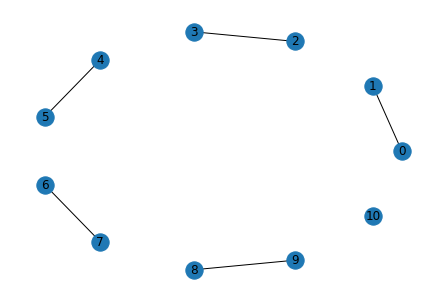

In [8]:
n=5
A = getLIclique(n)
M, B = simplecticnormalization(n, B=A)
print(M)
G = Delta(B)
draw(G)
plt.plot()

The next function is used to cut a set of Paulies into $k$ sets such that is minimize the size of the biggest connected components.

In [9]:
def partition(B,k):
    G = Delta(B)
    partition = [[] for _ in range(k)]
    ConnectedComps = nx.connected_components(G)
    for ConnectedComp in ConnectedComps:
        for i, v in enumerate(random.sample(list(ConnectedComp), len(ConnectedComp))):
            partition[i%k].append(v)
    while partition[-1] == []:
        del(partition[-1])
    return partition

A = getLIclique(20)
partition(A, 7)

[[33, 9, 15, 27, 40, 1],
 [23, 34, 3, 16, 4, 32],
 [11, 21, 26, 30, 19, 7],
 [17, 35, 24, 8, 6, 22],
 [0, 28, 39, 12, 25, 2],
 [20, 29, 38, 10, 18, 37],
 [14, 31, 5, 13, 36]]

Here, the goal is to generate some datasets of famillies of Pauli strings. 
 
With no more constraint a way of doing it is to shuffling the set of Paulies 
and return some adjacent set of random length. 

For linearly independent family of Paulies. A nice idea is to start from the canonical simplecticonormal basis and then apply many random star operation in order to cover with high probability every equivalence class of canonical form. 

In [10]:
def generate_Pauli_dataset(n):
    data = list(q.pauli_group(n))
    random.shuffle(data)
    organized_data = [[]]
    for k, p in enumerate(data):
        organized_data[-1].append(p)
        if random.random() > .95 and k < len(data) - 1:
            organized_data.append([])
    return organized_data

def generate_free_Pauli_dataset(n, size, step):
    canonical_simplectico_normal_basis = [q.Pauli.from_sparse({i:q.X}, nq=n) for i in range(n)] + [q.Pauli.from_sparse({i:q.Z}, nq=n) for i in range(n)]
    data_set = []
    for k in range(size):
        print("Current Pauli set under construction", k, end="\r")
        current = canonical_simplectico_normal_basis.copy()
        for j in range(step):
            e = random.randint(0, 2*n-1)
            f = random.randint(0, 2*n-1)
            while f==e:
                f = random.randint(0, 2*n-1)
            star_op(current, e, f)
        data_set.append(current.copy())
    print()
    return data_set

In [11]:
generate_free_Pauli_dataset(1, 10, 10)

Current Pauli set under construction 9


[[i^0 X, i^0 Z],
 [i^3 Y, i^0 X],
 [i^2 Z, i^1 Y],
 [i^3 Y, i^0 X],
 [i^0 X, i^0 Z],
 [i^2 Z, i^1 Y],
 [i^3 Y, i^0 X],
 [i^3 Y, i^2 X],
 [i^3 Y, i^2 X],
 [i^3 Y, i^2 X]]

Some utility function to compute weights

In [12]:
def max_weight_pauli_set(pauli_set):
    return max(map(lambda p : p.wt, pauli_set))

def max_weight_tableau_repr(pauli_set):
    n = pauli_set.shape[1]//2
    return np.max(np.sum(np.logical_or(pauli_set[:,:n], pauli_set[:,n:]), 1))

Here, on lauch the Symplectic gram schmidt on random set of Pauly strings, not always linearly independent. Let check up the weight in output. 

In [13]:
DS = generate_Pauli_dataset(4)
avg = 0
for k, pauli_set in enumerate(DS):
    g = Delta(pauli_set)
    S, dtB = simplecticnormalization(4, pauli_set)
    g2 = Delta(dtB)
    print(max_weight_pauli_set(pauli_set), max_weight_tableau_repr(S))
    diff = max_weight_pauli_set(pauli_set)- max_weight_tableau_repr(S)
    avg += diff
    # draw(g)
    # plt.show()
    # draw(g2)
    # plt.show()
print("Average weight reduction:", avg/len(DS))

4 4
4 4
4 4
4 4
4 4
4 1
4 4
3 1
4 4
4 4
4 3
4 2
Average weight reduction: 0.6666666666666666


In [14]:
DS = generate_free_Pauli_dataset(6, 200, 200)
avg = 0
for k, pauli_set in enumerate(DS):
    # Compute graph
    g = Delta(pauli_set)
    S, dtB = simplecticnormalization(4, pauli_set)
    # compute the graph of the simplectico normal basis
    g2 = Delta(dtB)

    # print(max_weight_pauli_set(pauli_set), pauli_set)
    # print(max_weight_tableau_repr(S), S)
    diff = max_weight_pauli_set(pauli_set)- max_weight_tableau_repr(S)
    avg += diff
    # print both graph
    # draw(g)
    # plt.show()
    # draw(g2)
    # plt.show()
print("Average weight reduction:", avg/len(DS))

Current Pauli set under construction 199
Average weight reduction: 1.96


partitioning on any type of set 

In [15]:
DS = generate_Pauli_dataset(4)
partition_number = 4
for k, pauli_set in enumerate(DS):
    print("=====================================================================================================")
    g = Delta(pauli_set)
    print("Original_set:", pauli_set)
    partis = partition(pauli_set, partition_number)
    print("Partis:=",partis)
    max_weight=0
    for partie in partis:
        for i in range(len(partie)):
            partie[i] = pauli_set[partie[i]] 
        S, dtb = simplecticnormalization(4, partie)
        if max_weight_tableau_repr(S) > max_weight:
            max_weight = max_weight_tableau_repr(S)
    print("Output weight:", max_weight_pauli_set(pauli_set), max_weight)

Original_set: [i^0 XYYI, i^0 ZXII, i^0 IXZZ, i^0 ZYZZ, i^0 XYIZ, i^0 ZIXI, i^0 XXZZ, i^0 XZIZ, i^0 YIXX, i^0 ZXXX, i^0 ZYYY, i^0 YYXY, i^0 YZYI, i^0 XZXI, i^0 YYIY, i^0 IXZY, i^0 IYYI, i^0 XZYI, i^0 YIYY, i^0 IZIZ, i^0 YXXY, i^0 ZYZX, i^0 YXIX, i^0 XIYI, i^0 XIII, i^0 ZYXX, i^0 YIZZ, i^0 IZXX, i^0 XYZY, i^0 IZYI, i^0 ZYIY, i^0 XIIZ]
Partis:= [[6, 22, 2, 9, 23, 7, 5, 18], [16, 19, 21, 25, 4, 13, 17, 20], [24, 0, 12, 14, 30, 28, 8, 31], [10, 15, 26, 29, 11, 3, 1, 27]]
Output weight: 4 4
Original_set: [i^0 XXIY, i^0 ZXZZ, i^0 IYXZ, i^0 IIZX, i^0 XXYX, i^0 IXIY, i^0 IIZY, i^0 ZZYY, i^0 YIXZ, i^0 IXZX, i^0 ZYZY, i^0 IIYZ]
Partis:= [[7, 3, 4], [2, 6, 11], [0, 10, 1], [8, 9, 5]]
Output weight: 4 2
Original_set: [i^0 XZZY, i^0 ZZXI, i^0 IXXY, i^0 YZXY, i^0 IZIY, i^0 IIYI, i^0 IIIX, i^0 YIZX, i^0 IYXY, i^0 IIIY, i^0 ZZZX, i^0 YXXX, i^0 XXYZ, i^0 IIYY, i^0 ZIII, i^0 XZII, i^0 YZZI, i^0 YZYY, i^0 XYZZ, i^0 ZXZI, i^0 YZIY, i^0 ZZIY, i^0 IYYX, i^0 YZZX, i^0 ZXYX, i^0 XIYZ, i^0 IXYI, i^0 XYYZ, i^0 X

partitioning on linearly independant set of paulies.

In [16]:
Nb_Qubit=10
Nb_par = 4
Nb_test = 10
DS = generate_free_Pauli_dataset(Nb_Qubit, Nb_test, 900)
for k, pauli_set in enumerate(DS):
    # Compute graph
    g = Delta(pauli_set)
    S, dtB = simplecticnormalization(Nb_Qubit, pauli_set.copy())
    # compute the graph of the simplectico normal basis
    g2 = Delta(dtB)
    print("Initial max weight:", max_weight_pauli_set(pauli_set))
    print("Weight_after_algo:", max_weight_tableau_repr(S))#, S)

    partis = partition(pauli_set, Nb_par)
    print("partitions:", partis)
    max_weight=0
    for partie in partis:
        for i in range(len(partie)):
            partie[i] = pauli_set[partie[i]] 
        print(f"Partie {i}:", partie, end = " Weight after algo: ")
        S, dtb = simplecticnormalization(Nb_Qubit, partie)
        print(max_weight_tableau_repr(S))#, S)
        if max_weight_tableau_repr(S) > max_weight:
            max_weight = max_weight_tableau_repr(S)


    print("max weight after partition:", max_weight)
    # print both graph
    # draw(g)
    # plt.show()
    # draw(g2)
    # plt.show()
    print("==========================================================================")

Current Pauli set under construction 9
Initial max weight: 10
Weight_after_algo: 8
partitions: [[12, 4, 10, 16, 3], [9, 7, 5, 17, 18], [14, 0, 13, 19, 1], [11, 2, 8, 6, 15]]
Partie 4: [i^2 YZYYXZYYXY, i^1 ZZZYXXXYXY, i^2 YIYYYYIXYZ, i^0 YXYYIYIZZZ, i^0 ZXZXXYIYIZ] Weight after algo: 2
Partie 4: [i^1 ZZIIIZIXYZ, i^0 YIIYIZZYYZ, i^1 XIZIZIIIYZ, i^0 XYXYIIXXIX, i^2 IYYXYZXXYI] Weight after algo: 2
Partie 4: [i^2 ZYYYIXZYZZ, i^3 XIXXXXYYIY, i^2 XIYYYXZXYZ, i^2 YIXIXZYYYX, i^2 IXYXYYXYII] Weight after algo: 2
Partie 4: [i^2 YXZZZZXZXY, i^3 IYYXYXIXXZ, i^3 IYXZZYYZZX, i^2 XXZIXYZIYI, i^1 YYZIXYXIIX] Weight after algo: 4
max weight after partition: 4
Initial max weight: 9
Weight_after_algo: 7
partitions: [[19, 15, 16, 8, 17], [2, 13, 18, 0, 4], [6, 12, 10, 1, 11], [7, 9, 3, 5, 14]]
Partie 4: [i^0 IIXIZZXZZI, i^1 YZZYIYXXIX, i^3 XZIXIZZYZI, i^2 YZYZYZZIXY, i^0 XYYYIIYZIZ] Weight after algo: 2
Partie 4: [i^2 YYYXYYIZYZ, i^0 IIYZYZYXZY, i^2 IYZYYXYZYY, i^2 IIXYYXIXXZ, i^2 YIYYYZYYXZ] Weight afte

Try to print some curv to understand illustrate the report

In [17]:
N_max = 15
N_par_max = 6
N_test = 100
N_sample_max = 400

result = []
for current_n in range(1, N_max):
    print(current_n)
    DS = generate_free_Pauli_dataset(current_n, N_test, N_sample_max)
    data = [0 for _ in range(N_par_max+1)]
    for k, pauli_set in enumerate(DS):
        # Compute initial graph
        g = Delta(pauli_set)
        # store the weight
        init_weight = max_weight_pauli_set(pauli_set)
        data[0] += init_weight
        # compute data for all other partition number
        for p_number in range(1, N_par_max + 1):
            # for p_number number of set in the partition 
            partis = partition(pauli_set, p_number)
            max_weight=0
            # iterate on parts to find the max output weight 
            for partie in partis:
                # set up the parti 
                for i in range(len(partie)):
                    partie[i] = pauli_set[partie[i]] 
                # symplectic gram schmidt for the spacification 
                S, dtb = simplecticnormalization(Nb_Qubit, partie)
                # update if higher
                if max_weight_tableau_repr(S) > max_weight:
                    max_weight = max_weight_tableau_repr(S)
            # add the best to the data 
            data[p_number] += max_weight
    result.append([d / len(DS) for d in data]+[(data[0] - data[i])/len(DS) for i in range(1, N_par_max+1)])

1
Current Pauli set under construction 99
2
Current Pauli set under construction 99
3
Current Pauli set under construction 99
4
Current Pauli set under construction 99
5
Current Pauli set under construction 99
6
Current Pauli set under construction 99
7
Current Pauli set under construction 99
8
Current Pauli set under construction 99
9
Current Pauli set under construction 99
10
Current Pauli set under construction 99
11
Current Pauli set under construction 99
12
Current Pauli set under construction 99
13
Current Pauli set under construction 99
14
Current Pauli set under construction 99


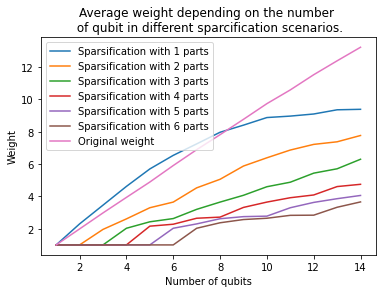

In [23]:
import matplotlib.pyplot as plt

result = np.array(result)
rang = range(1, N_max)

plot1 = plt.subplot()

plot1.set_title("Average weight depending on the number \n of qubit in different sparcification scenarios.")
plot1.set_xlabel("Number of qubits")
plot1.set_ylabel("Weight")
for i in range(1, N_par_max+1):
    plot1.plot(rang, result[:, i], label=f"Sparsification with {i} parts")
plot1.plot(rang, result[:, 0], label="Original weight")
plot1.legend()





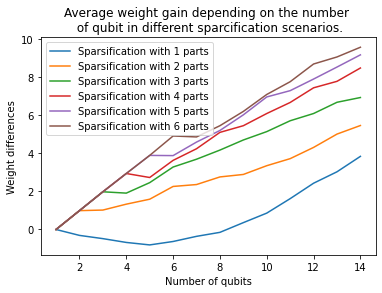

In [27]:
plot2 = plt.subplot()
plot2.set_title("Average weight gain depending on the number \n of qubit in different sparcification scenarios.")
plot2.set_xlabel("Number of qubits")
plot2.set_ylabel("Weight differences")
for i in range(1, N_par_max+1):
    plot2.plot(rang, result[:, i+N_par_max], label=f"Sparsification with {i} parts")
plot2.legend()

# test de minimal weight en sorti

# Test click small

In [29]:
import qecc as q
from qecc import X,Y,Z
nq = 20
A = [q.Pauli.from_sparse({0:X}, nq=nq), q.Pauli.from_sparse({0:Y},nq=nq),q.Pauli.from_sparse({0:Z},nq=nq)]

for i in range(1, nq):
    q0 = A[0]
    q1 = q0 * q.Pauli.from_sparse({i:X}, nq=nq)
    q2 = q0 * q.Pauli.from_sparse({i:Y},nq=nq)
    q3 = q0 * q.Pauli.from_sparse({i:Z},nq=nq)
    A+=[q1,q2,q3]
    del(A[0])
    #print(A)

print(len(A))
print(max(list(map(lambda x : x.wt, A ))))
G = Delta(A)
print(G.degree)

41
4
[(0, 40), (1, 40), (2, 40), (3, 40), (4, 40), (5, 40), (6, 40), (7, 40), (8, 40), (9, 40), (10, 40), (11, 40), (12, 40), (13, 40), (14, 40), (15, 40), (16, 40), (17, 40), (18, 40), (19, 40), (20, 40), (21, 40), (22, 40), (23, 40), (24, 40), (25, 40), (26, 40), (27, 40), (28, 40), (29, 40), (30, 40), (31, 40), (32, 40), (33, 40), (34, 40), (35, 40), (36, 40), (37, 40), (38, 40), (39, 40), (40, 40)]
